In [1]:
import pydicom
import nibabel as nib
import dicom2nifti
import os
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from skimage.exposure import equalize_adapthist

# Visualizing Infarct (red) and Mirrored (green) area on CT scan

Original Scan Raw Voxel Intensity (min, max):  -32768 32767


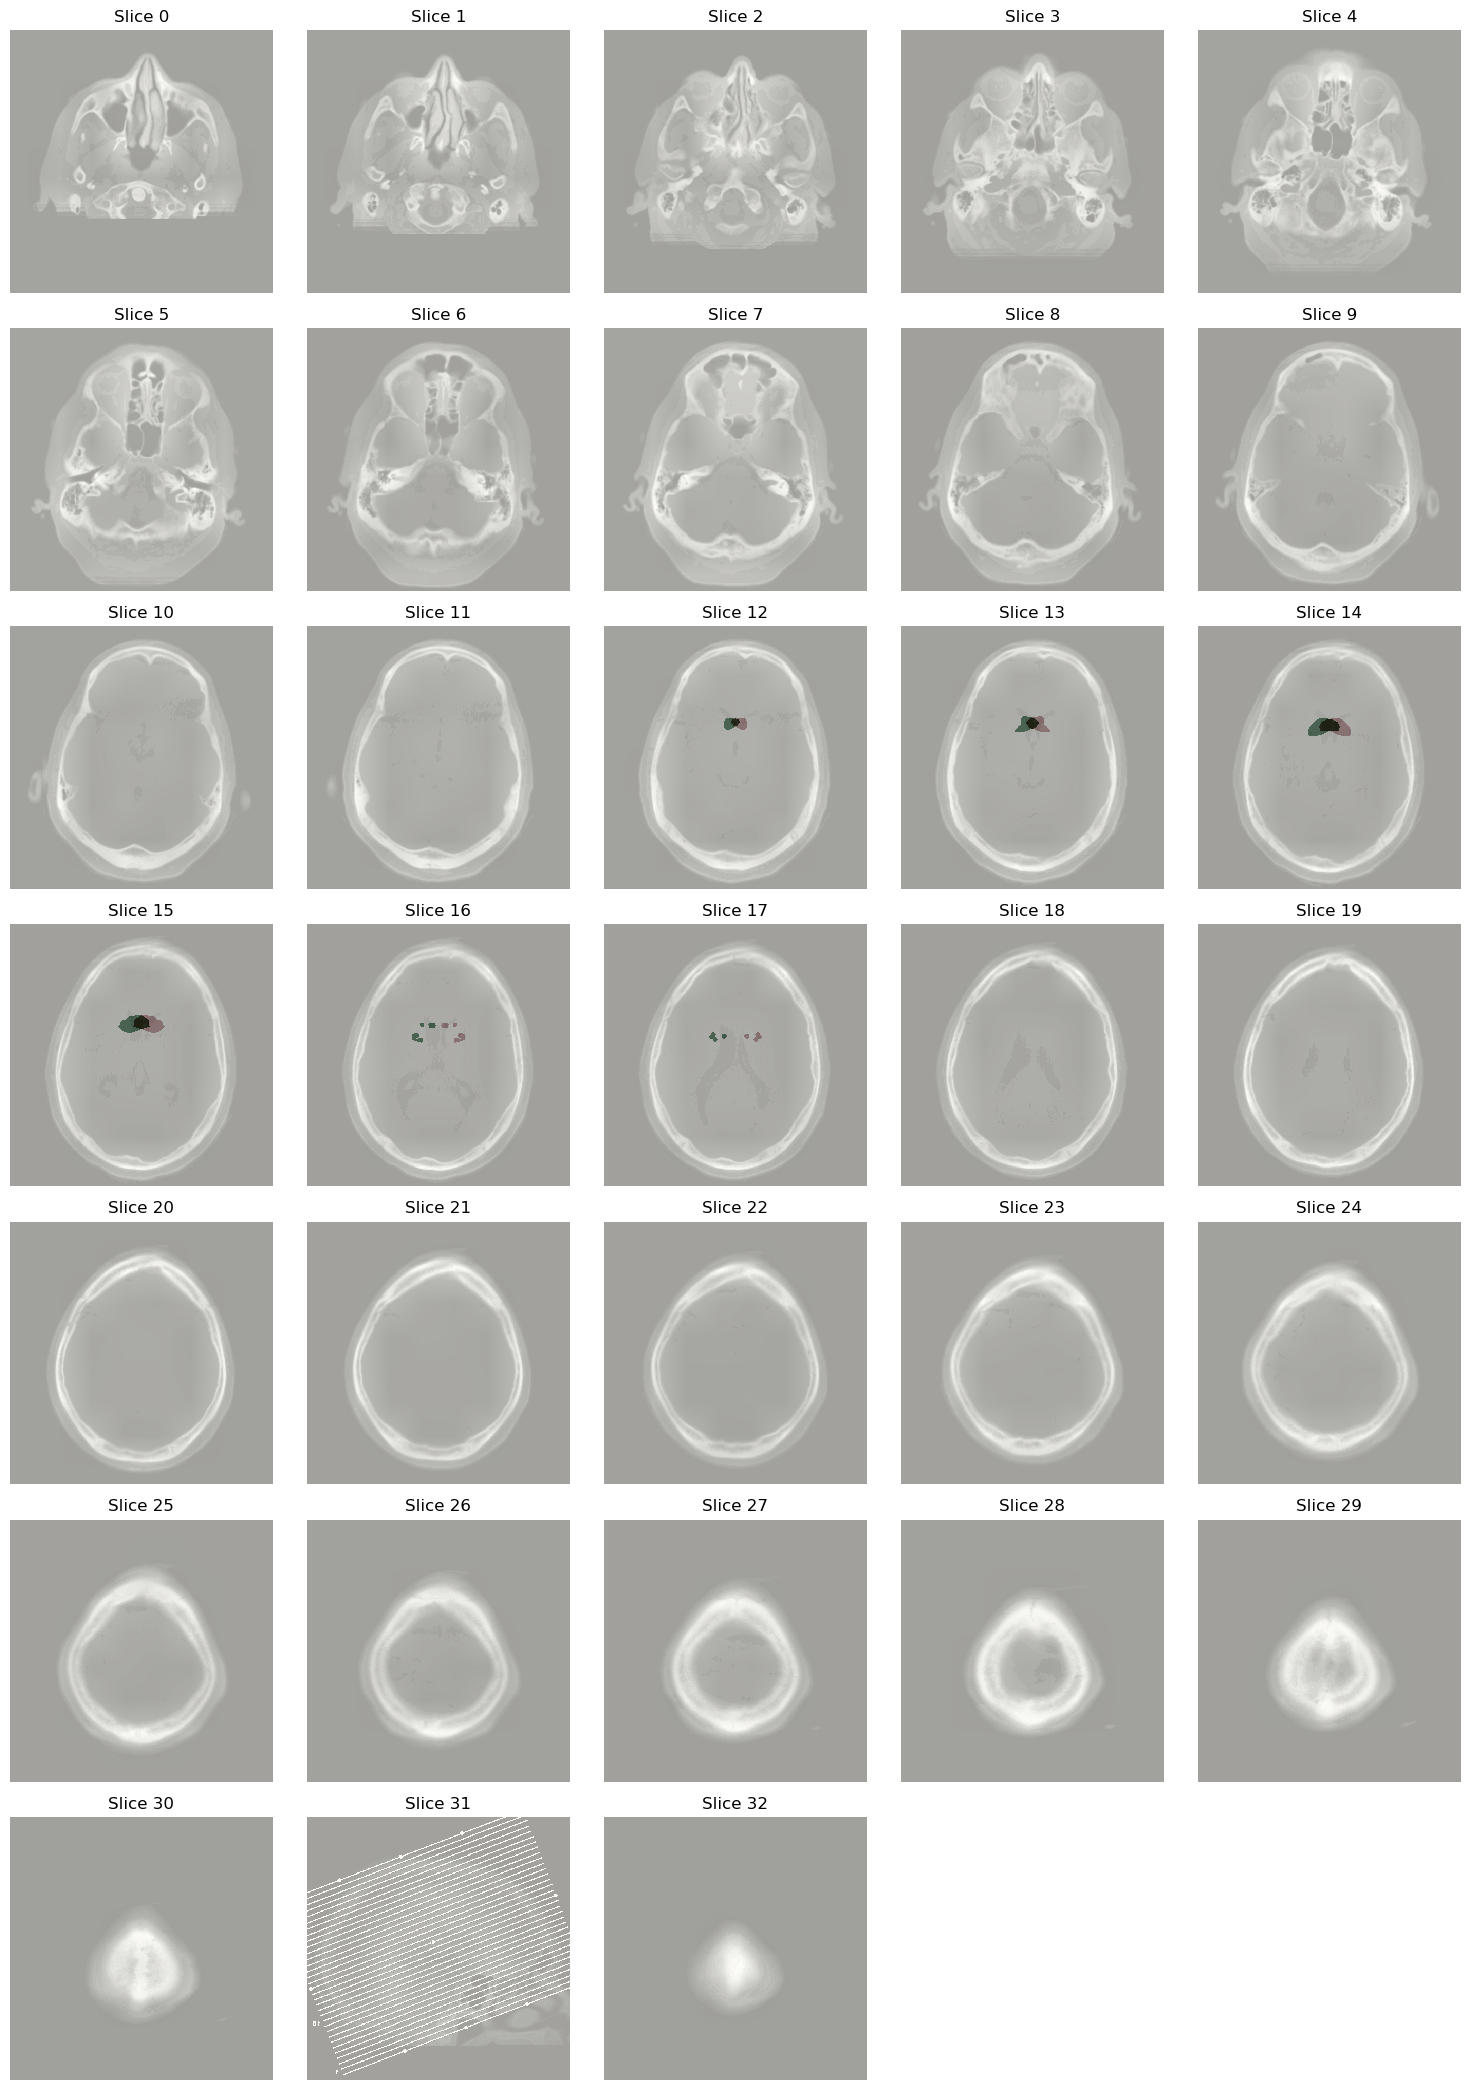

In [2]:
# Loading both original scan and mask for infarct segment
scan_path = r"C:\Users\anikd\Desktop\Stroke_Project\original_scans_nifti\Escapena1_01-076_5029494465612187.nii.gz"
mask_path = r"C:\Users\anikd\Desktop\Stroke_Project\infarct_segmentation\01-076seg.nii.gz"

scan = sitk.ReadImage(scan_path)
mask = sitk.ReadImage(mask_path)
scan_array = sitk.GetArrayFromImage(scan)  
mask_array = sitk.GetArrayFromImage(mask)
print("Original Scan Raw Voxel Intensity (min, max): ", np.min(scan_array), np.max(scan_array))

scan_array = np.rot90(scan_array, k=3, axes=(1, 2))
mask_array = np.rot90(mask_array, k=3, axes=(1, 2))
visualizing_scan_array = equalize_adapthist(scan_array, clip_limit=0.05)
mask_array_mirrored = np.flip(mask_array, axis=2)

# Determining the smaller number of slices
n_slices = min(scan_array.shape[0], mask_array.shape[0])
n_cols = 5
n_rows = (n_slices + n_cols - 1) // n_cols

# Creating a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
for i in range(n_slices):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.imshow(visualizing_scan_array[i], cmap="gray", interpolation="none")
    ax.imshow(mask_array[i], cmap="Reds", alpha=0.4, interpolation="none")  # Original infarct area in red
    ax.imshow(mask_array_mirrored[i], cmap="Greens", alpha=0.4, interpolation="none")  # Mirrored infarct area in green
    ax.axis("off")
    ax.set_title(f"Slice {i}")

# Hiding any empty subplots
for i in range(n_slices, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis("off")

plt.tight_layout()
plt.show()

# Measuring the Hounsfield Unit (HU) for DICOM CT Scan

In [3]:
# loading dicom folder and binary mask
dicom_folder = r"C:\Users\anikd\Desktop\Stroke_Project\original_scans_dicom\Escapena1_01-076_5029494465612187"

# Listing all dicom files and sorting slices
dcm_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
dcm_files.sort()

# Initialize a list to store raw pixel data and RescaleSlope and RescaleIntercept
ct_pixels = []
rescale_slopes = []
rescale_intercepts = []

# Interating through all dicom files
for dcm_file in dcm_files:
    dcm_data = pydicom.dcmread(os.path.join(dicom_folder, dcm_file))

    ct_pixels.append(dcm_data.pixel_array)
    rescale_slopes.append(dcm_data.get('RescaleSlope', 1))
    rescale_intercepts.append(dcm_data.get('RescaleIntercept', 0))

# Using the first consistent value for RescaleSlope and RescaleIntercept
rescale_slope = rescale_slopes[0]
rescale_intercept = rescale_intercepts[0]

# Converting the list of pixels into a 3D numpy array
ct_pixels = np.stack(ct_pixels, axis=-1)

# Converting the pixel data to Hounsfield Units (HU)
ct_hu = ct_pixels * rescale_slope + rescale_intercept

# Print the RescaleSlope, RescaleIntercept, and maximum HU value
print(f"RescaleSlope: {rescale_slope}")
print(f"RescaleIntercept: {rescale_intercept}\n")
print(f"Scan shape: {ct_hu.shape}")
print(f"Minimum HU value: {ct_hu.min()}")
print(f"Maximum HU value: {ct_hu.max()}")

RescaleSlope: 1.0
RescaleIntercept: -1024.0

Scan shape: (512, 512, 34)
Minimum HU value: -33792.0
Maximum HU value: 31743.0


# Calculating Mean, Median, and STD for Infarct area (red) and Mirrored area (green) -- Based on Hounsfield Unit (HU)

In [4]:
# Loading the binary mask
mask= nib.load(r"C:\Users\anikd\Desktop\Stroke_Project\infarct_segmentation\01-076seg.nii.gz")
mask_array = mask.get_fdata()
scan_array = ct_hu

# Mirroring the mask by flipping left-right axis (horizontal)
mask_array_mirrored = np.flip(mask_array, axis=2)

# Finding the minimum number of slices between scan and mask followed by trimming to match the dimension
min_slices = min(scan_array.shape[2], mask_array.shape[2])

scan_array = scan_array[:, :, :min_slices]
mask_array = mask_array[:, :, :min_slices]
mask_array_mirrored = mask_array_mirrored[:, :, :min_slices]

# Applying the mask to extract infarct and mirrored area from scan
scan_infarct_area = scan_array * mask_array
scan_mirrored_area = scan_array * mask_array_mirrored

# Calculating statistics on the infarct area
infarct_area_mean = np.mean(scan_infarct_area[scan_infarct_area > 0])
infarct_area_median = np.median(scan_infarct_area[scan_infarct_area > 0])
infarct_area_std = np.std(scan_infarct_area[scan_infarct_area > 0])
infarct_area_voxel_count = np.sum(scan_infarct_area > 0)

# Calculating statistics for the mirrored area
mirrored_area_mean = np.mean(scan_mirrored_area[scan_mirrored_area > 0])
mirrored_area_median = np.median(scan_mirrored_area[scan_mirrored_area > 0])
mirrored_area_std = np.std(scan_mirrored_area[scan_mirrored_area > 0])

# Printing the results for infarct and mirrored area
print(f"Mean:               {infarct_area_mean:.2f} (Infarct) vs {mirrored_area_mean:.2f} (Mirrored)\n")
print(f"Median:             {infarct_area_median:.2f} (Infarct) vs {mirrored_area_median:.2f} (Mirrored)\n")
print(f"Standard Deviation: {infarct_area_std:.2f} (Infarct) vs {mirrored_area_std:.2f} (Mirrored)\n")
print(f"Voxel count:        {infarct_area_voxel_count}")

Mean:               20.00 (Infarct) vs 25.74 (Mirrored)

Median:             22.00 (Infarct) vs 27.00 (Mirrored)

Standard Deviation: 9.13 (Infarct) vs 7.47 (Mirrored)

Voxel count:        4696
